cxns_noDup = connectivity matrix. 

Each entry is # of synapses between a single neuron pair. Presynaptic partner goes down the rows, postsynaptic partner goes across the columns. 
    
lineNames_nosub = the name of each cell type (or split-GAL4 line). Each cell type contains 1 to >100 individual neurons, and some cell types are split into subtypes (ie, 'B1-1, 'B1-2', etc)

neuronNames = name of each neuron in the connectivity matrix. Each name is unique. The beginning part of the name indicates which cell type the neuron is from (ie, '16374_L1' is from cell type 16374, and 'WV-WV-1_L1' is from cell type WV-WV).

I have ignored the diagonal values (which would represent autapses) by inserting NaNs. In my connectivity diagram, I have also ignored connections between individual neurons that belong to the same cell type due to the high rate of false positives of the automatically detected synapses in these cases. 

For the current connectome figure, I set a threshold of 15 synapses between one single pair of neurons to indicate a likely connection, and then required at least 3% of all possible connections between two cell types (in one direction) to cross this threshold.  

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from scipy import stats
import sys

from aux import loadmat_h5
from disp import set_font_size

DATA_FILE = 'data/christa/allAudNeurons_connMat_noDupSyn.mat'

In [2]:
data = loadmat_h5(DATA_FILE)
print(data.keys())

w_orig = data['cxns_noDup']
print(w_orig)

dict_keys(['cxns_noDup', 'lineNames_nosub', 'neuronNames'])
[[ nan  42. 133. ...   0.   0.   0.]
 [ 55.  nan  77. ...   0.   0.   0.]
 [ 31.  44.  nan ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...  nan   1.   6.]
 [  0.   0.   0. ...   7.  nan  11.]
 [  0.   0.   0. ...   3.   0.  nan]]


In [3]:
data['lineNames_nosub']

array([['A1', 'A2', 'B1', 'B2', 'GF', 'WED-VLP', 'WV-WV', '16374',
        '27885', '27936', '36007', '37007', '40303', '41728', '41730',
        '43299', '21914', '29146', '35996', '47261', '23281', '27932',
        '29136', '35916', '36012', '38918', '40316', '41739', '45858',
        'vpoEN', 'vpoIN', 'pMN1', 'pMN2', 'pC2', 'pC1']], dtype=object)

In [4]:
data['neuronNames'].T

array([['A1_L1', 'A1_L2', 'A1_L3', 'A1_R1', 'A1_R2', 'A2_L', 'A2_R',
        'B1-1_L1', 'B1-1_L2', 'B1-1_L3', 'B1-1_L4', 'B1-1_L5', 'B1-1_L6',
        'B1-1_R1', 'B1-1_R2', 'B1-1_R3', 'B1-1_R4', 'B1-1_R5', 'B1-1_R6',
        'B1-2_L1', 'B1-2_L2', 'B1-2_L3', 'B1-2_L4', 'B1-2_L5', 'B1-2_L6',
        'B1-2_L7', 'B1-2_L8', 'B1-2_L9', 'B1-2_R1', 'B1-2_R2', 'B1-2_R3',
        'B1-2_R4', 'B1-2_R5', 'B1-2_R6', 'B1-2_R7', 'B1-2_R8', 'B1-3_L1',
        'B1-3_L2', 'B1-3_L3', 'B1-3_L4', 'B1-3_L5', 'B1-3_R1', 'B1-3_R2',
        'B1-3_R3', 'B1-3_R4', 'B1-3_R5', 'B1-4_L1', 'B1-4_L2', 'B1-4_L3',
        'B1-4_L4', 'B1-4_L5', 'B1-4_L6', 'B1-4_L7', 'B1-4_L8', 'B1-4_L9',
        'B1-4_R1', 'B1-4_R2', 'B1-4_R3', 'B1-4_R4', 'B1-4_R5', 'B1-4_R6',
        'B1-4_R7', 'B1-4_R8', 'B1-u_L1', 'B1-u_L2', 'B1-u_L3', 'B1-u_L4',
        'B1-u_L5', 'B1-u_L6', 'B1-u_L7', 'B1-u_L8', 'B1-u_L9',
        'B1-u_L10', 'B1-u_L11', 'B1-u_L12', 'B1-u_L13', 'B1-u_L14',
        'B1-u_L15', 'B1-u_L16', 'B1-u_L17', 'B1-u_L18', 'B1-

In [5]:
w = np.nan * np.zeros((len(data['lineNames_nosub'].flatten()), len(data['lineNames_nosub'].flatten())))

for cpre, pre in enumerate(data['lineNames_nosub'].flatten()):
    m_pre = np.array([neuron.startswith(pre) for neuron in data['neuronNames'].flatten()])
    for cpost, post in enumerate(data['lineNames_nosub'].flatten()):
        m_post = np.array([neuron.startswith(post) for neuron in data['neuronNames'].flatten()])
        
        w[cpre, cpost] = np.nansum(w_orig[m_pre, :][:, m_post])
    
print(f'w.shape = {w.shape}')

w.shape = (35, 35)


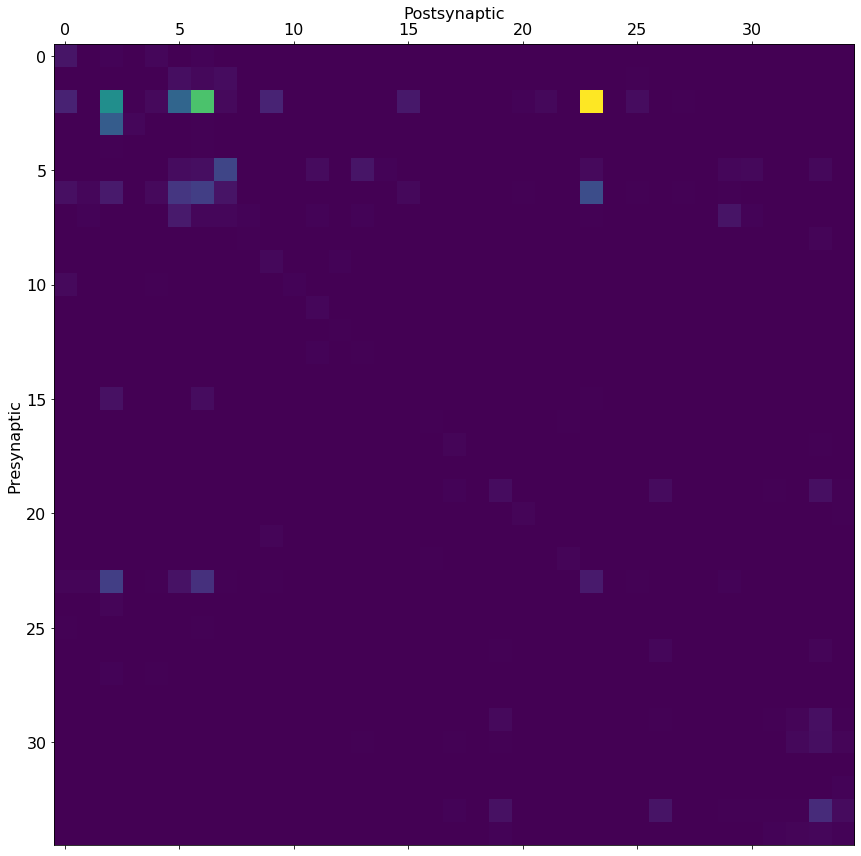

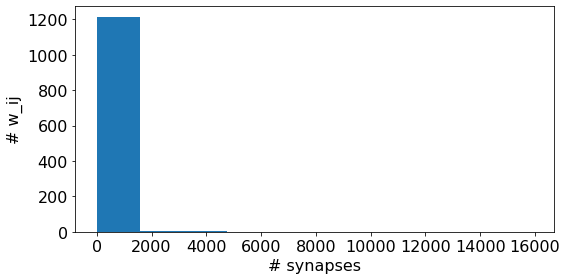

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12), tight_layout=True)
ax.matshow(w)
ax.set_xlabel('Postsynaptic')
ax.set_ylabel('Presynaptic')
ax.xaxis.set_label_position('top')

set_font_size(ax, 16)

fig, ax = plt.subplots(1, 1, figsize=(8, 4), tight_layout=True)
ax.hist(w.flatten())
ax.set_xlabel('# synapses')
ax.set_ylabel('# w_ij')
set_font_size(ax, 16)

In [7]:
print(np.mean(w[w > 0]))
print(np.median(w[w > 0]))
print(np.max(w))

193.26344086021504
10.0
15897.0


In [28]:
w.sum()

107841.0

In [8]:
np.sum(w > 0)

558

In [9]:
w.size

1225

In [10]:
np.sum(w >= 100)

103

In [11]:
np.sum(w > 1)

470

Metrics from [corominasmurtra2013origins](https://www.pnas.org/content/110/33/13316) (Rodriguez-Caso) PNAS. On the origins of hierarchy in complex networks.

In [12]:
def get_gc(g):
    """Return graph condensation."""
    scc = list(nx.strongly_connected_components(g))
    gc = nx.algorithms.components.condensation(g, scc=scc)
    return gc, scc

def calc_treeness(gc):
    """Return treeness."""
    
    assert nx.is_directed_acyclic_graph(gc)
    
    k_ins = gc.in_degree()
    k_outs = gc.out_degree()
    
    max_nodes = np.array([v for v, k_in in k_ins if k_in == 0])
    min_nodes = np.array([v for v, k_out in k_outs if k_out == 0])
    
    if len(max_nodes) == len(min_nodes) == len(gc):
        return 0., 0., 0.
   
    h_fwds = []
    for v in max_nodes:
        # count all paths from v to each min_node
        paths = sum([list(nx.all_simple_paths(gc, v, u)) for u in min_nodes if (u != v and nx.has_path(gc, v, u))], [])
        
        if len(paths) == 0:
            h_fwds.append(0)  # only one path from v (to self), so 0 entropy
            continue
            
        p_paths = np.array([np.prod([1/k_outs[v_] for v_ in path[:-1]]) for path in paths])  # prob of path is product of all out_degrees along path
        
        np.testing.assert_almost_equal(np.sum(p_paths), 1)
        p_paths /= np.sum(p_paths)
        
        h_fwds.append(stats.entropy(p_paths, base=2))
        
    h_fwd = np.sum(h_fwds)/len(max_nodes)
    
    h_baks = []
    for u in min_nodes:
        # count all paths to u from each max_node
        paths = sum([list(nx.all_simple_paths(gc, v, u)) for v in max_nodes if (u != v and nx.has_path(gc, v, u))], [])
        
        if len(paths) == 0:
            h_fwds.append(0)  # only one path to u (from self), so 0 entropy
            continue
    
        p_paths = np.array([np.prod([1/k_ins[u_] for u_ in path[1:]]) for path in paths])  # prob of path is product of all in_degrees along path
        
        np.testing.assert_almost_equal(np.sum(p_paths), 1)
        p_paths /= np.sum(p_paths)
        
        h_baks.append(stats.entropy(p_paths, base=2))
        
    h_bak = np.sum(h_baks)/len(min_nodes)
    
    return (h_fwd - h_bak) / max(h_fwd, h_bak), h_fwd, h_bak


def calc_feedforwardness(gc):
    """Return feedforwardness"""
    k_ins = gc.in_degree()
    k_outs = gc.out_degree()
    
    max_nodes = np.array([v for v, k_in in k_ins if k_in == 0])
    min_nodes = np.array([v for v, k_out in k_outs if k_out == 0])
    
    if len(max_nodes) == len(min_nodes) == len(gc):
        return 0.
    
    alph = {i: len(gc.nodes[i]['members']) for i in gc.nodes()}
    
    paths_all = []
    p_paths_all = []

    for v in max_nodes:
#         paths = sum([list(nx.all_simple_paths(gc, v, u)) for u in min_nodes if nx.has_path(gc, v, u)], [])
        paths = sum([list(nx.all_simple_paths(gc, v, u)) for u in min_nodes if (u != v and nx.has_path(gc, v, u))], [])
        
        if len(paths) == 0:
            continue
            
        p_paths = [np.prod([1/k_outs[v_] for v_ in path[:-1]]) for path in paths]
        
        np.testing.assert_almost_equal(np.sum(p_paths), 1)
        p_paths /= np.sum(p_paths)
        
        paths_all.extend(paths)
        p_paths_all.extend(p_paths)
        
    p_paths_all = np.array(p_paths_all) / len(max_nodes)
    
    ffs = []
    
    for path in paths_all:
        
        ffs.append(len(path)/np.sum([alph[i] for i in path]))
    
    return np.mean(ffs)

def calc_orderability(gc):
    """Return orderability."""
    k_ins = gc.in_degree()
    k_outs = gc.out_degree()
    
    max_nodes = np.array([v for v, k_in in k_ins if k_in == 0])
    min_nodes = np.array([v for v, k_out in k_outs if k_out == 0])
       
    alph = np.array([len(gc.nodes[v]['members']) for v in gc.nodes() if (k_ins[v] or k_outs[v])])
    
    return np.sum(alph == 1)/alph.sum()

Test graphs

In [13]:
adj_a = np.array([
    [0, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 1, 1],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
])

adj_b = np.array([
    [0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0],
])

adj_c = np.array([
    [0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 0, 1, 1],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
])

adj_d = np.array([
    [0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
])

g_a = nx.from_numpy_array(adj_a, create_using=nx.DiGraph)
g_b = nx.from_numpy_array(adj_b, create_using=nx.DiGraph)
g_c = nx.from_numpy_array(adj_c, create_using=nx.DiGraph)
g_d = nx.from_numpy_array(adj_d, create_using=nx.DiGraph)

In [14]:
gc_a, scc_a = get_gc(g_a)
gc_b, scc_b = get_gc(g_b)
gc_c, scc_c = get_gc(g_c)
gc_d, scc_d = get_gc(g_d)

In [15]:
t_a = calc_treeness(gc_a)[0]
t_b = calc_treeness(gc_b)[0]
t_c = calc_treeness(gc_c)[0]
t_d = calc_treeness(gc_d)[0]

f_a = calc_feedforwardness(gc_a)
f_b = calc_feedforwardness(gc_b)
f_c = calc_feedforwardness(gc_c)
f_d = calc_feedforwardness(gc_d)

o_a = calc_orderability(gc_a)
o_b = calc_orderability(gc_b)
o_c = calc_orderability(gc_c)
o_d = calc_orderability(gc_d)

In [16]:
print(f'T(A) = {t_a}, F(A) = {f_a}, O(A) = {o_a}')
print(f'T(B) = {t_b}, F(A) = {f_b}, O(B) = {o_b}')
print(f'T(C) = {t_c}, F(A) = {f_c}, O(C) = {o_c}')
print(f'T(D) = {t_d}, F(A) = {f_d}, O(D) = {o_d}')

T(A) = 1.0, F(A) = 1.0, O(A) = 1.0
T(B) = -1.0, F(A) = 1.0, O(B) = 1.0
T(C) = 0.0, F(A) = 1.0, O(C) = 1.0
T(D) = 1.0, F(A) = 0.625, O(D) = 0.5


Should be:

`T(A) = 1.0, F(A) = 1.0, O(A) = 1.0`

`T(B) = -1.0, F(A) = 1.0, O(B) = 1.0`

`T(C) = 0.0, F(A) = 1.0, O(C) = 1.0`

`T(D) = 1.0, F(A) = 0.625, O(D) = 0.5`

Analyze fly graph

In [17]:
adj_fly_test = (w >= 5)
g_fly_test = nx.from_numpy_array(adj_fly_test, create_using=nx.DiGraph)
gc_fly_test, scc_fly_test = get_gc(g_fly_test)

t_fly_test = calc_treeness(gc_fly_test)[0]
f_fly_test = calc_feedforwardness(gc_fly_test)
o_fly_test = calc_orderability(gc_fly_test)

In [18]:
try:
    df_tfo_fly = pd.read_csv('data/christa/cb3_fly_hierarchy_metrics.csv')
except:
    # loop over num synapses used to define a connection
    min_syns = np.array([1, 5, 10, 50, 100])

    ts_fly = np.nan * np.zeros(len(min_syns))
    fs_fly = np.nan * np.zeros(len(min_syns))
    os_fly = np.nan * np.zeros(len(min_syns))
    alphs_all = []

    for cms, min_syn in enumerate(min_syns):
        sys.stdout.write('.')
        adj_fly = w >= min_syn

        g_fly = nx.from_numpy_array(adj_fly, create_using=nx.DiGraph)
        gc_fly, scc_fly = get_gc(g_fly)

        t_fly = calc_treeness(gc_fly)[0]
        f_fly = calc_feedforwardness(gc_fly)
        o_fly = calc_orderability(gc_fly)

        ts_fly[cms] = t_fly
        fs_fly[cms] = f_fly
        os_fly[cms] = o_fly

        alphs_all.append([len(scc) for scc in scc_fly])

    dicts_tfo_fly = [
        {'min_syn': min_syn, 'treeness': t_fly, 'feedforwardness': f_fly, 'orderability': o_fly, 'num_scc': len(alphs)}
        for min_syn, t_fly, f_fly, o_fly, alphs in zip(min_syns, ts_fly, fs_fly, os_fly, alphs_all)
    ]
    df_tfo_fly = pd.DataFrame(columns=['min_syn', 'treeness', 'feedforwardness', 'orderability', 'num_scc'], data=dicts_tfo_fly)
    df_tfo_fly.to_csv('data/christa/cb3_fly_hierarchy_metrics.csv', index=False)

.....

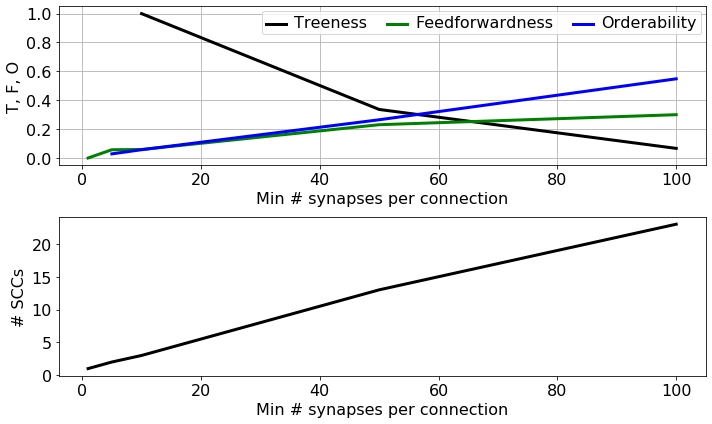

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(10, 6), tight_layout=True)
axs[0].plot(df_tfo_fly['min_syn'], df_tfo_fly['treeness'], c='k', lw=3)
axs[0].plot(df_tfo_fly['min_syn'], df_tfo_fly['feedforwardness'], c='g', lw=3)
axs[0].plot(df_tfo_fly['min_syn'], df_tfo_fly['orderability'], c='b', lw=3)

axs[0].set_xlabel('Min # synapses per connection')
axs[0].set_ylabel('T, F, O')
axs[0].legend(['Treeness', 'Feedforwardness', 'Orderability'], ncol=3)
axs[0].grid()

axs[1].plot(df_tfo_fly['min_syn'], df_tfo_fly['num_scc'], c='k', lw=3)
axs[1].set_xlabel('Min # synapses per connection')
axs[1].set_ylabel('# SCCs')

set_font_size(axs, 16)

# Draw condensed fly graph

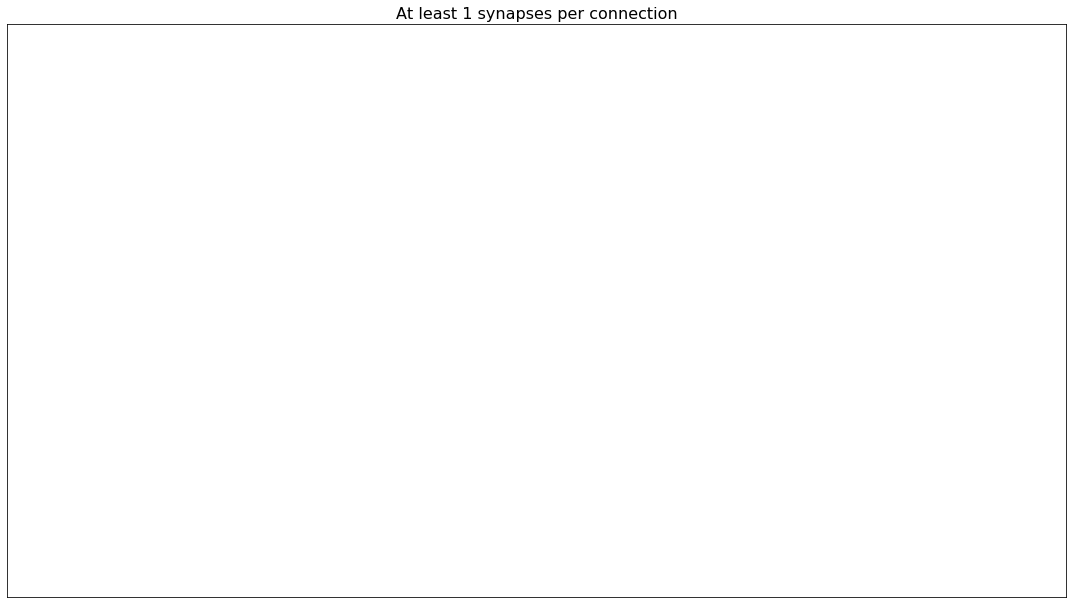

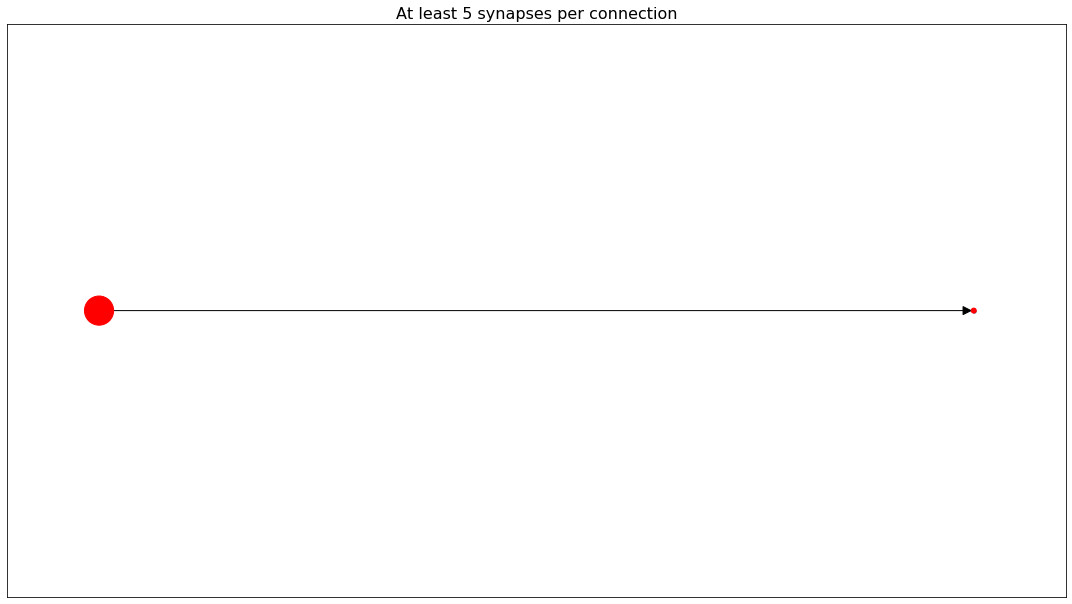

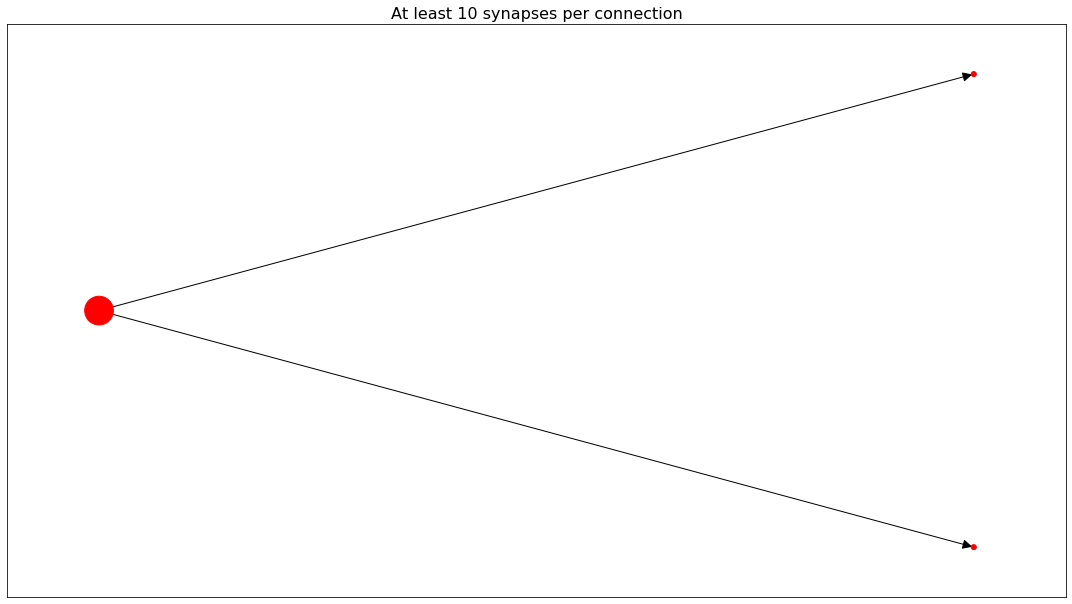

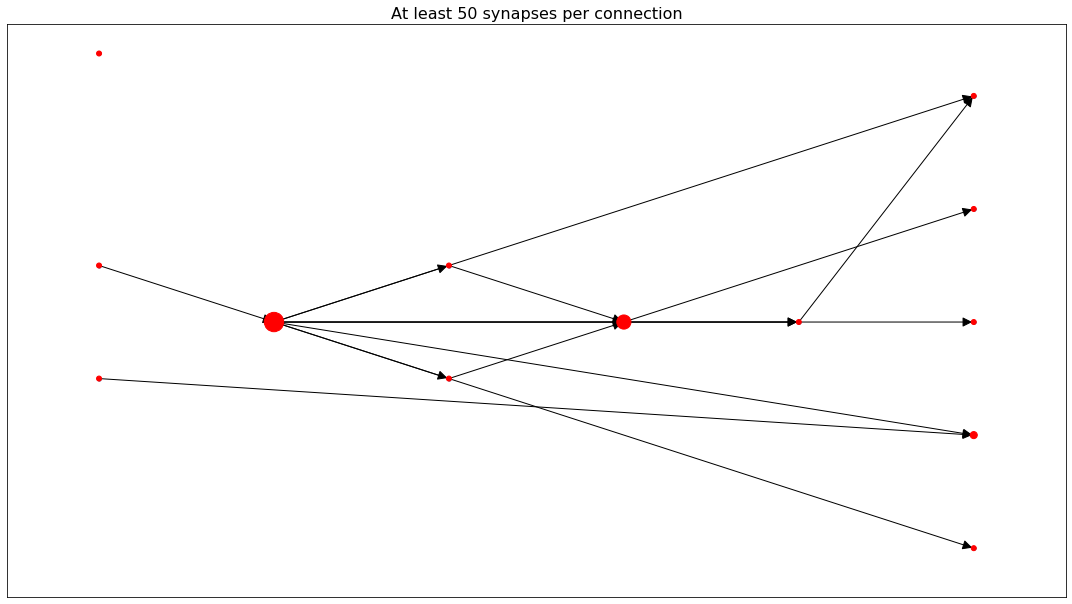

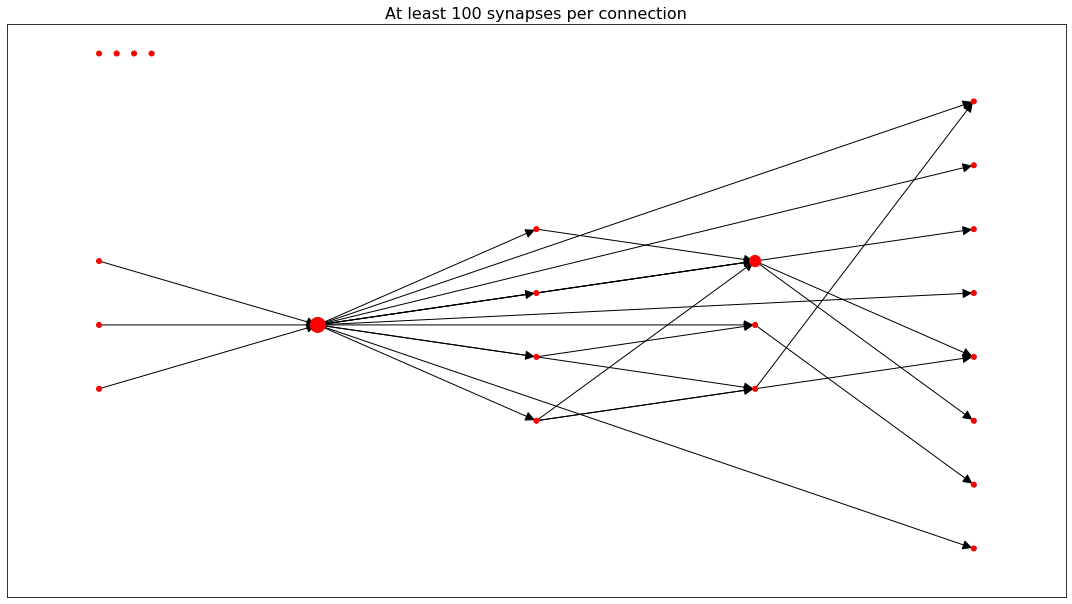

In [20]:
min_syns_rand = np.array([1, 5, 10, 50, 100])

for cs, min_syn in enumerate(min_syns_rand):
    
    g_fly = nx.from_numpy_array(w >= min_syn, create_using=nx.DiGraph)
    gc_fly, scc_fly = get_gc(g_fly)
    
    # get graphical attributes of nodes
    assert nx.is_directed_acyclic_graph(gc_fly)
    
    node_list = np.array(list(gc_fly.nodes()))
    
    k_ins = gc_fly.in_degree()
    k_outs = gc_fly.out_degree()
    
    max_nodes = np.array([v for v, k_in in k_ins if k_in == 0])
    
    xs = {v: 0 for v in max_nodes}
    member_dict = {v: gc_fly.nodes()[v]['members'] for v in gc_fly.nodes()}
    
    prev_nodes = max_nodes.copy()
    
    for i in range(100):
        # get all children of previous set of nodes
        child_list = sum([list(gc_fly.successors(v)) for v in prev_nodes], [])
        
        if not child_list:
            break
        next_nodes = np.array(list(set(child_list)))
        
        for v in next_nodes:
            xs[v] = i+1
            
        prev_nodes = next_nodes
    else:
        raise Exception('for loop reached 100 iters')
    
    for v in node_list:
        if k_ins[v] == k_outs[v] == 0:
            xs[v] = np.nan
            
    x_max = np.nanmax(list(xs.values()))
    for v in node_list:
        if k_outs[v] == 0 and k_ins[v] > 0:
            xs[v] = x_max
         
    # set y positions
    ys = {v: np.nan for v in node_list}
    for x_ in xs.values():
        nodes_this_x = [v for v in gc_fly.nodes() if xs[v] == x_]
        ys_ = np.random.permutation(len(nodes_this_x))
        for y_, v_ in zip(ys_, nodes_this_x):
            ys[v_] = y_ - len(nodes_this_x)/2
            
    pos = {v: (xs[v], ys[v]) for v in node_list}
    alphs = np.array([len(member_dict[v]) for v in node_list])
    
    unconnected = [v for v in node_list if np.isnan(pos[v][0])]
    n_unconnected = len(unconnected)
    
    xr = np.nanmax(list(xs.values())) - np.nanmin(list(xs.values()))
    x_unc = np.nanmin(list(xs.values())) + xr/50 * (np.arange(n_unconnected)%50)
    y_unc = np.nanmax(list(ys.values()))*(1.25 + .05*(np.arange(n_unconnected) // 50))
    
    for cv, v in enumerate(unconnected):
        pos[v] = (x_unc[cv], y_unc[cv])
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 8.5), tight_layout=True)
    nx.drawing.draw_networkx(gc_fly, pos=pos, node_size=10, ax=ax, with_labels=False, arrowsize=20)
    ax.scatter(*zip(*[pos[v] for v in node_list]), s=25*alphs, zorder=1000, c='r')
    ax.set_title(f'At least {min_syn} synapses per connection')
    
    set_font_size(ax, 16)

## Null model comparison

Erdos-Renyi


min_syn = 1............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

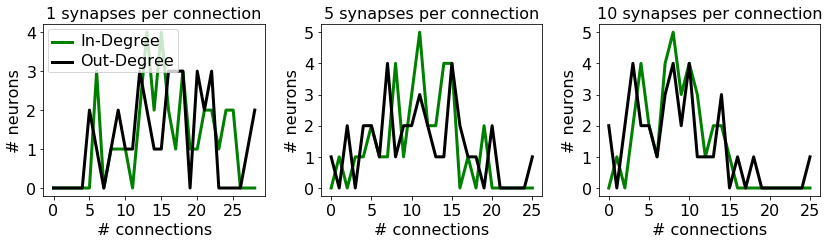

In [23]:
try:
    df_tfo_er = pd.read_csv('data/christa/ER3_hierarchy_metrics.csv')
except:
    SEED = 0
    n_seed = 1000
    n_neur = w.shape[0]
    min_syns_rand = np.array([1, 5, 10, 50, 100])

    ts_er_all = []
    fs_er_all = []
    os_er_all = []

    fig, axs = plt.subplots(1, 3, figsize=(12, 3.5), tight_layout=True)

    for cms, min_syn in enumerate(min_syns_rand):
        adj_fly = (w >= min_syn)

        m_in = np.mean(np.sum(adj_fly, 0))
        m_out = np.mean(np.sum(adj_fly, 1))

        np.testing.assert_almost_equal(m_in, m_out)

        g_fly = nx.from_numpy_array(adj_fly, create_using=nx.DiGraph)
        node_list = list(g_fly.nodes())

        k_in = np.array([g_fly.in_degree()[v] for v in node_list])
        k_out = np.array([g_fly.out_degree()[v] for v in node_list])

        np.testing.assert_almost_equal(m_in, np.mean(k_in))
        np.testing.assert_almost_equal(m_out, np.mean(k_out))

        p_er = np.sum(adj_fly)/(n_neur*(n_neur-1))

        bins = np.arange(2 + np.max([np.max(k_in), np.max(k_out)])) - .5
        binc = .5*(bins[:-1] + bins[1:])
        cts_in = np.histogram(k_in, bins)[0]
        cts_out = np.histogram(k_out, bins)[0]
        try:
            axs[cms].plot(binc, cts_in, lw=3, c='g')
            axs[cms].plot(binc, cts_out, lw=3, c='k')

            if cms == 0:
                axs[cms].legend(['In-Degree', 'Out-Degree'])
            axs[cms].set_xlabel('# connections')
            axs[cms].set_ylabel('# neurons')
            axs[cms].set_title(f'{min_syn} synapses per connection')
        except:
            pass

        ts_er = []
        fs_er = []
        os_er = []

        sys.stdout.write(f'\nmin_syn = {min_syn}')
        for cs in range(n_seed):
            np.random.seed(cs + SEED)
            adj_er = np.random.rand(n_neur, n_neur) < p_er
            np.fill_diagonal(adj_er, 0)

            g_er = nx.from_numpy_array(adj_er, create_using=nx.DiGraph)

            gc_er, scc_er = get_gc(g_er)

            ts_er.append(calc_treeness(gc_er)[0])
            fs_er.append(calc_feedforwardness(gc_er))
            os_er.append(calc_orderability(gc_er))

            sys.stdout.write('.')

        ts_er_all.append(ts_er)
        fs_er_all.append(fs_er)
        os_er_all.append(os_er)

    set_font_size(axs, 16)
    
    dict_tfo_er = []

    for cms, min_syn in enumerate(min_syns_rand):
        dict_tfo_er.extend([
            {'min_syn': min_syn, 'trial': trial+1, 'treeness': t_er, 'feedforwardness': f_er, 'orderability': o_er}
            for trial, (t_er, f_er, o_er) in enumerate(zip(ts_er_all[cms], fs_er_all[cms], os_er_all[cms]))
        ])

    df_tfo_er = pd.DataFrame(columns=['min_syn', 'trial', 'treeness', 'feedforwardness', 'orderability'], data=dict_tfo_er)
    df_tfo_er.to_csv('data/christa/ER3_hierarchy_metrics.csv', index=False)

Configuration model


min_syn = 1............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

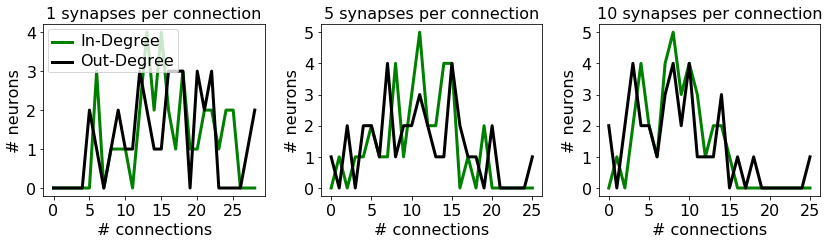

In [24]:
try:
    df_tfo_cm = pd.read_csv('data/christa/CM3_hierarchy_metrics.csv')
except:
    SEED = 0
    n_seed = 1000
    n_neur = w.shape[0]
    min_syns_rand = np.array([1, 5, 10, 50, 100])

    ts_cm_all = []
    fs_cm_all = []
    os_cm_all = []

    fig, axs = plt.subplots(1, 3, figsize=(12, 3.5), tight_layout=True)

    for cms, min_syn in enumerate(min_syns_rand):
        adj_fly = (w >= min_syn)

        m_in = np.mean(np.sum(adj_fly, 0))
        m_out = np.mean(np.sum(adj_fly, 1))

        np.testing.assert_almost_equal(m_in, m_out)

        g_fly = nx.from_numpy_array(adj_fly, create_using=nx.DiGraph)
        node_list = list(g_fly.nodes())

        k_in = np.array([g_fly.in_degree()[v] for v in node_list])
        k_out = np.array([g_fly.out_degree()[v] for v in node_list])

        np.testing.assert_almost_equal(m_in, np.mean(k_in))
        np.testing.assert_almost_equal(m_out, np.mean(k_out))

        bins = np.arange(2 + np.max([np.max(k_in), np.max(k_out)])) - .5
        binc = .5*(bins[:-1] + bins[1:])
        cts_in = np.histogram(k_in, bins)[0]
        cts_out = np.histogram(k_out, bins)[0]

        try:
            axs[cms].plot(binc, cts_in, lw=3, c='g')
            axs[cms].plot(binc, cts_out, lw=3, c='k')

            if cms == 0:
                axs[cms].legend(['In-Degree', 'Out-Degree'])
            axs[cms].set_xlabel('# connections')
            axs[cms].set_ylabel('# neurons')
            axs[cms].set_title(f'{min_syn} synapses per connection')
        except:
            pass

        ts_cm = []
        fs_cm = []
        os_cm = []

        gs_cm = []

        sys.stdout.write(f'\nmin_syn = {min_syn}')
        for cs in range(n_seed):
            np.random.seed(cs + SEED)

            g_cm = nx.directed_configuration_model(in_degree_sequence=k_in, out_degree_sequence=k_out)
            gs_cm.append(g_cm)

            gc_cm, scc_cm = get_gc(g_cm)

            ts_cm.append(calc_treeness(gc_cm)[0])
            fs_cm.append(calc_feedforwardness(gc_cm))
            os_cm.append(calc_orderability(gc_cm))

            sys.stdout.write('.')

        ts_cm_all.append(ts_cm)
        fs_cm_all.append(fs_cm)
        os_cm_all.append(os_cm)

    set_font_size(axs, 16)
    
    dict_tfo_cm = []

    for cms, min_syn in enumerate(min_syns_rand):
        dict_tfo_cm.extend([
            {'min_syn': min_syn, 'trial': trial+1, 'treeness': t_cm, 'feedforwardness': f_cm, 'orderability': o_cm}
            for trial, (t_cm, f_cm, o_cm) in enumerate(zip(ts_cm_all[cms], fs_cm_all[cms], os_cm_all[cms]))
        ])

    df_tfo_cm = pd.DataFrame(columns=['min_syn', 'trial', 'treeness', 'feedforwardness', 'orderability'], data=dict_tfo_cm)
    df_tfo_cm.to_csv('data/christa/CM3_hierarchy_metrics.csv', index=False)

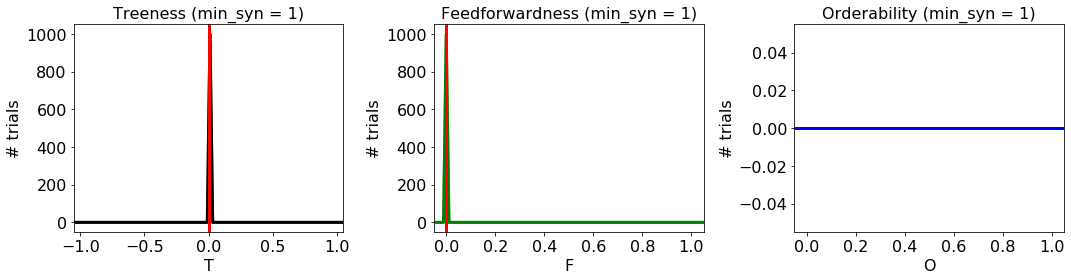

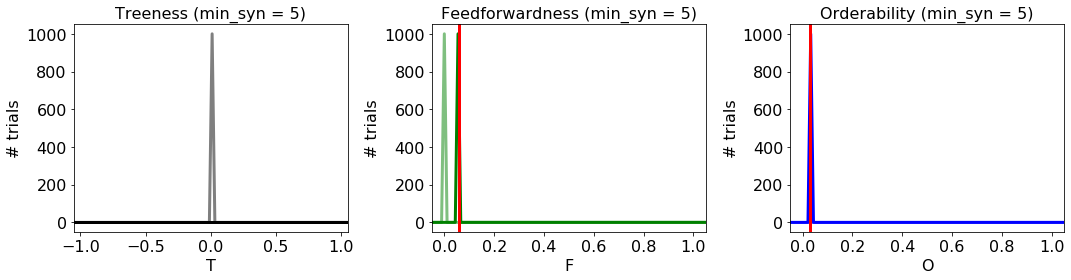

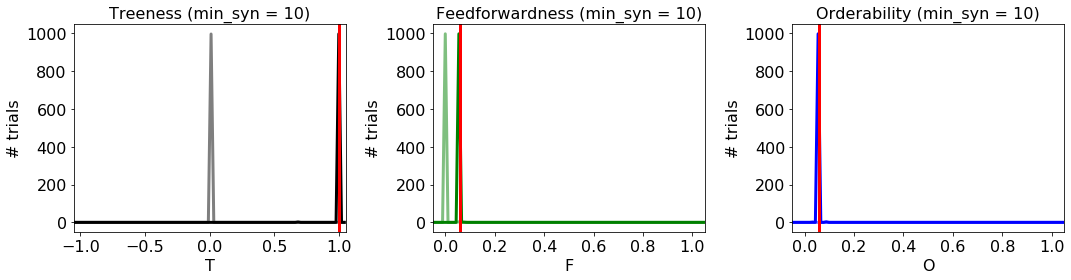

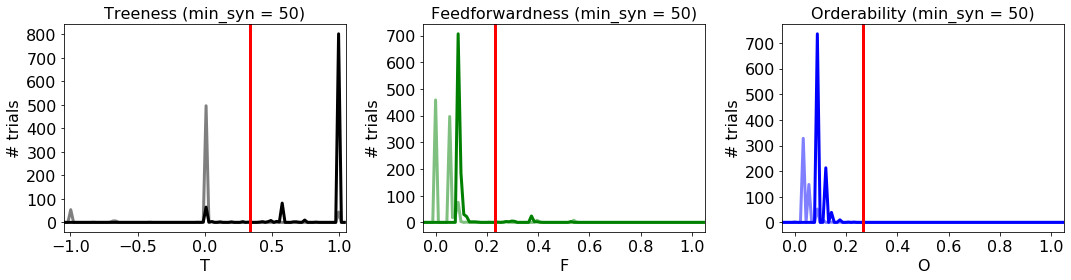

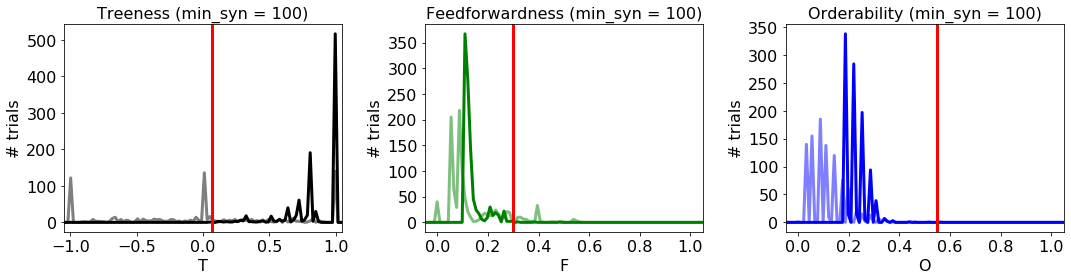

In [26]:
bins_t = np.linspace(-1.05, 1.05, 101)
binc_t = .5*(bins_t[:-1] + bins_t[1:])
bins_f = np.linspace(-0.05, 1.05, 101)
binc_f = .5*(bins_f[:-1] + bins_f[1:])
bins_o = np.linspace(-0.05, 1.05, 101)
binc_o = .5*(bins_o[:-1] + bins_o[1:])

for cms, min_syn in enumerate(min_syns_rand):
    
    cts_t_er = np.histogram(df_tfo_er[df_tfo_er['min_syn']==min_syn]['treeness'], bins=bins_t)[0]
    cts_f_er = np.histogram(df_tfo_er[df_tfo_er['min_syn']==min_syn]['feedforwardness'], bins=bins_f)[0]
    cts_o_er = np.histogram(df_tfo_er[df_tfo_er['min_syn']==min_syn]['orderability'], bins=bins_o)[0]
    
    cts_t_cm = np.histogram(df_tfo_cm[df_tfo_cm['min_syn']==min_syn]['treeness'], bins=bins_t)[0]
    cts_f_cm = np.histogram(df_tfo_cm[df_tfo_cm['min_syn']==min_syn]['feedforwardness'], bins=bins_f)[0]
    cts_o_cm = np.histogram(df_tfo_cm[df_tfo_cm['min_syn']==min_syn]['orderability'], bins=bins_o)[0]
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 4), tight_layout=True)
    
    axs[0].plot(binc_t, cts_t_er, c='k', lw=3, alpha=.5)
    axs[0].plot(binc_t, cts_t_cm, c='k', lw=3)
    axs[0].axvline(df_tfo_fly[df_tfo_fly['min_syn']==min_syn]['treeness'].iloc[0], lw=3, color='r')
    axs[0].set_xlim(-1.05, 1.05)
    axs[0].set_xticks([-1, -.5, 0, .5, 1])
    axs[0].set_xlabel('T')
    axs[0].set_title(f'Treeness (min_syn = {min_syn})')
    
    axs[1].plot(binc_f, cts_f_er, c='g', lw=3, alpha=.5)
    axs[1].plot(binc_f, cts_f_cm, c='g', lw=3)
    axs[1].axvline(df_tfo_fly[df_tfo_fly['min_syn']==min_syn]['feedforwardness'].iloc[0], lw=3, color='r')
    axs[1].set_xlim(-.05, 1.05)
    axs[1].set_xlabel('F')
    axs[1].set_title(f'Feedforwardness (min_syn = {min_syn})')
    
    axs[2].plot(binc_o, cts_o_er, c='b', lw=3, alpha=.5)
    axs[2].plot(binc_o, cts_o_cm, c='b', lw=3)
    axs[2].axvline(df_tfo_fly[df_tfo_fly['min_syn']==min_syn]['orderability'].iloc[0], lw=3, color='r')
    axs[2].set_xlim(-.05, 1.05)
    axs[2].set_xlabel('O')
    axs[2].set_title(f'Orderability (min_syn = {min_syn})')
    
    for ax in axs:
        ax.set_ylabel('# trials')
        set_font_size(ax, 16)